In [58]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt

We will use the [FGNET dataset](https://yanweifu.github.io/FG_NET_data/) for this lab.It is a dataset for age estimation and face recognition across ages. It is composed of a total of 1,002 images with 82 people aged 0 to 69. It is often used for face verification across large age gaps. The dataset contains images ranging from child/young to adult/old.


The `.npz` files `data_age` and `data_age_test` respectively, contain the precomputed AAM features for the dataset.


In [59]:
train_file = 'data_age.npz'
test_file = 'data_age_test.npz'
train = np.load(train_file)
test = np.load(test_file)

In [60]:
class FGNET(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_data = FGNET(train['features'], train['labels'])
test_data = FGNET(test['features'], test['labels'])


train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# 1. Linear Regression

We will use pytorch [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer and Stochastic Gradient Descent [(SGD)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=sgd) to do the age estimation. We will use the Mean Absolute Error [(MAE)](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html?highlight=mae)

Task 1: Train a linear regression model using pytorch on Age Estimation.

In [65]:
### YOUR CODE HERE
# Step 1: Create a sequential model with a single nn.Linear layer. 
# Set the number of inputs and outputs according to the dimensionality of 
# the features and labels accordingly
model = nn.Sequential(nn.Linear(201, 1))

# Step 2: Create an SGD optimizer
# Hint: check pytorch API
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Step 3: Create the mae criterion
criterion = nn.L1Loss()

# Step 4: Train the model
for epoch in range(50):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # print(inputs.dtype, targets.dtype)
        optimizer.zero_grad()
        outputs = model(inputs.to(torch.float32))
        # print("outputs", outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

Task 2: Apply the learned linear regressionmodel to estimate the age for each test data point. Compute the MAE and CS value (with a cumulative error level of 5) by comparing the estimated ages with the ground truth ages.

In [66]:
### YOUR CODE HERE
test_data_samples = torch.from_numpy(test_data.data).float()
test_data_labels = torch.from_numpy(test_data.labels)
test_pred_lregr = model(test_data_samples)

lregr_loss = nn.L1Loss()
mae_lregr = lregr_loss(test_pred_lregr, test_data_labels)

print("MAE using trained linear regression model - ", mae_lregr.detach())

MAE using trained linear regression model -  tensor(8.1156)


In [67]:
abs_error_lregr = abs(test_pred_lregr - test_data_labels).detach()
cummulative_err_lvl = 5

def get_cum_score(arr, err_lvl):
  count = 0
  total = arr.shape[0]
  for i in arr:
    if (i <= err_lvl):
      count += 1
  result = (count/total) *100

  return result

cs_value = get_cum_score(abs_error_lregr, cummulative_err_lvl)
print("CS value using trained linear regression model - ", cs_value)

CS value using trained linear regression model -  33.46613545816733


Vary the cumulative error level from 1 to 15 and generate a plot of the CS value against the cumulative error level.

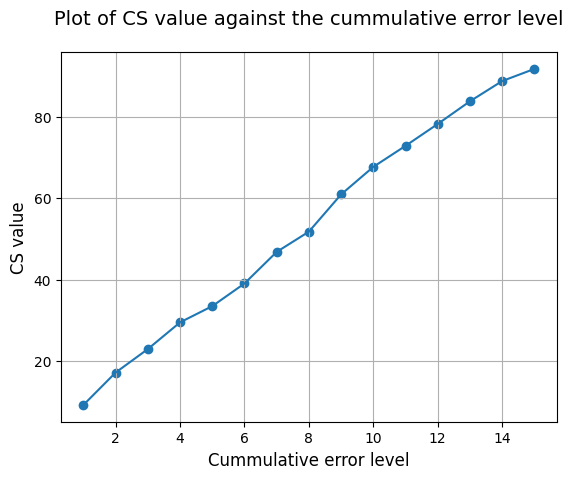

In [68]:
### YOUR CODE HERE
error_levels = list(range(1, 16))
cs_values = []

for lvl in error_levels:
  value = get_cum_score(abs_error_lregr, lvl)
  cs_values.append(value)


fig, ax = plt.subplots() 
ax.set_title('Plot of CS value against the cummulative error level', fontsize=14, pad=20.0)
ax.set_xlabel('Cummulative error level', fontsize=12)
ax.set_ylabel('CS value', fontsize=12)
ax.grid(True)
ax.plot(error_levels, cs_values)
ax.scatter(error_levels, cs_values)
fig.show()

# 2. PLS and Regression tree

We will compare the results of the linear regression above with Partial Least Squares and Regression Tree methods.

For this we will use scikit-learn [PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) and [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

Task 4: Compute the MAE and CS values (with cumulative error level of 5) for both partial least square regression model and the regression tree model.

In [69]:
train_data, train_labels = train['features'], train['labels']
test_data, test_labels = test['features'], test['labels']

test_labels = torch.from_numpy(test_labels)

In [70]:
### YOUR CODE HERE
# PLS Regression
pls_regr = PLSRegression()
pls_regr.fit(train_data, train_labels)

test_pred_pls = pls_regr.predict(test_data)
test_pred_pls = torch.from_numpy(test_pred_pls)

pls_loss = nn.L1Loss()
mae_pls = pls_loss(test_pred_pls, test_labels)

print("MAE using PLS Regression - ", mae_pls.detach())

MAE using PLS Regression -  tensor(6.8433, dtype=torch.float64)


In [71]:
abs_error_pls = abs(test_pred_pls - test_labels)
cummulative_err_lvl = 5

cs_value = get_cum_score(abs_error_pls, cummulative_err_lvl)
print("CS value using PLS Regression - ", cs_value)

CS value using PLS Regression -  45.81673306772908


In [76]:
### YOUR CODE HERE
# Regression Tree
dtree_regr = DecisionTreeRegressor(criterion='absolute_error')
dtree_regr.fit(train_data, train_labels)

test_pred_dtree = dtree_regr.predict(test_data)
test_pred_dtree = torch.from_numpy(test_pred_dtree.reshape(test_labels.shape))

dtree_loss = nn.L1Loss()
mae_dtree = dtree_loss(test_pred_dtree, test_labels)

print("MAE using Decision Tree Regressor - ", mae_dtree)

MAE using Decision Tree Regressor -  tensor(7.6155, dtype=torch.float64)


In [77]:
abs_error_dtree = abs(test_pred_dtree - test_labels)
cummulative_err_lvl = 5

cs_value = get_cum_score(abs_error_dtree, cummulative_err_lvl)
print("CS value using Decision Tree Regressor - ", cs_value)

CS value using Decision Tree Regressor -  55.37848605577689


# 3. SVR

Task 5:  Compute the MAE and CS values (with cumulative error level of 5) for Support Vector Regression.

In [78]:
### YOUR CODE HERE
sv_regr = SVR(kernel='poly')
sv_regr.fit(train_data, train_labels.reshape(-1))

test_pred_svr = sv_regr.predict(test_data)
test_pred_svr = torch.from_numpy(test_pred_svr.reshape(test_labels.shape))

svr_loss = nn.L1Loss()
mae_svr = svr_loss(test_pred_svr, test_labels)

print("MAE using Support Vector Regression - ", mae_svr)

MAE using Support Vector Regression -  tensor(5.6501, dtype=torch.float64)


In [79]:
abs_error_svr = abs(test_pred_svr - test_labels)
cummulative_err_lvl = 5

cs_value = get_cum_score(abs_error_svr, cummulative_err_lvl)
print("CS value using Support Vector Regression - ", cs_value)

CS value using Support Vector Regression -  57.96812749003985
